In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

# Función para calcular el promedio móvil
def moving_average(x, window_size):
    return np.array(
        [
            np.mean(x[i : i + window_size])
            for i in range(len(x) - window_size + 1)
        ]
    )


# Configuración

In [3]:
# Cargar datos del CSV
csv_file = "sel_audios_50.csv" # Ruta al CSV de referencia para datos de audio
data = pd.read_csv(csv_file)

# Parámetros de configuración
plot_segment = True # Graficar un segmento en específico (True), o la totalidad (False)
segment = (0, 10) # Inicio y final en segundos del segmento a graficar
window_size = 200 # Determina qué tan suavizado será la curva de media móvil
n = 50 # Cantidad de audios a graficar

# Función para graficar

In [21]:
def plot_by_category(data, category_column, title, num_audios_to_plot, audio_dir_label):
    total_audios_available = len(data)
    if num_audios_to_plot > total_audios_available:
        num_audios_to_plot = total_audios_available

    missing_files = set()
    short_audios = []

    categories = data[category_column].unique()
    plt.figure(figsize=(10, 6))
    colors = plt.colormaps["Set1"](np.linspace(0, 1, len(categories)))

    all_avg_frequencies = []
    all_avg_magnitudes = []
    total_plotted_audios = 0

    for idx, category in enumerate(categories):
        subset = data[data[category_column] == category]
        all_frequencies = []
        all_magnitudes = []

        for _, row in subset.iterrows():
            if total_plotted_audios >= num_audios_to_plot:
                break

            audio_file = row["nombre"]
            audio_path = os.path.join(audio_dir_label, audio_file)

            if not os.path.exists(audio_path):
                missing_files.add(audio_file)
                continue

            y, sr = librosa.load(audio_path)
            audio_duration = librosa.get_duration(y=y, sr=sr)
            if audio_duration < segment[1]:
                short_audios.append(audio_file)
                continue

            total_plotted_audios += 1

            start_sample = int(segment[0] * sr)
            end_sample = int(segment[1] * sr)
            y = y[start_sample:end_sample]

            fft_result = np.fft.fft(y)
            frequencies = np.fft.fftfreq(len(fft_result), 1 / sr)
            magnitude = np.abs(fft_result)

            positive_frequencies = frequencies[: len(frequencies) // 2]
            positive_magnitude_db = 20 * np.log10(
                magnitude[: len(magnitude) // 2] + 1e-9
            )

            all_frequencies.append(positive_frequencies)
            all_magnitudes.append(positive_magnitude_db)

            plt.plot(
                positive_frequencies,
                positive_magnitude_db,
                color=colors[idx],
                linewidth=0.3,
                alpha=0.05,
            )

        if all_frequencies:
            min_length = min(len(f) for f in all_frequencies)
            all_frequencies = [f[:min_length] for f in all_frequencies]
            all_magnitudes = [m[:min_length] for m in all_magnitudes]

            avg_frequencies = np.mean(all_frequencies, axis=0)
            avg_magnitude_db = np.mean(all_magnitudes, axis=0)

            all_avg_frequencies.append(avg_frequencies)
            all_avg_magnitudes.append(avg_magnitude_db)

    for idx, (avg_frequencies, avg_magnitude_db) in enumerate(
        zip(all_avg_frequencies, all_avg_magnitudes)
    ):
        smoothed_magnitude_db = moving_average(avg_magnitude_db, window_size)
        plt.plot(
            avg_frequencies[: len(smoothed_magnitude_db)],
            smoothed_magnitude_db,
            label=f"{categories[idx]}",
            color=colors[idx],
            linewidth=1.5,
        )

    plt.title(title)
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud (dB)")
    plt.grid(True)
    plt.xticks(np.arange(0, max(avg_frequencies), step=500), rotation=45)
    plt.legend(loc="upper right", fontsize="small")
    
    plt.annotate(
        f"Directorio: {audio_dir_label}\nSegmento: {segment[1] - segment[0]} s (de {segment[0]} s a {segment[1]} s)\nn = {total_plotted_audios}",
        xy=(0.02, 0.05),
        xycoords="axes fraction",
        ha="left", 
        fontsize=10,
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"
        ),
    )
    
    plt.tight_layout()
    plt.show()

    if missing_files:
        print(f"Audios ausentes: {len(missing_files)}")
        for archivo in missing_files:
            print(f"Archivo no encontrado: {archivo}")

    if short_audios:
        print(f"Audios demasiado corto: {len(short_audios)}")
        for audio in short_audios:
            print(f"Longitud insuficiente: {audio}")


# Spleeter

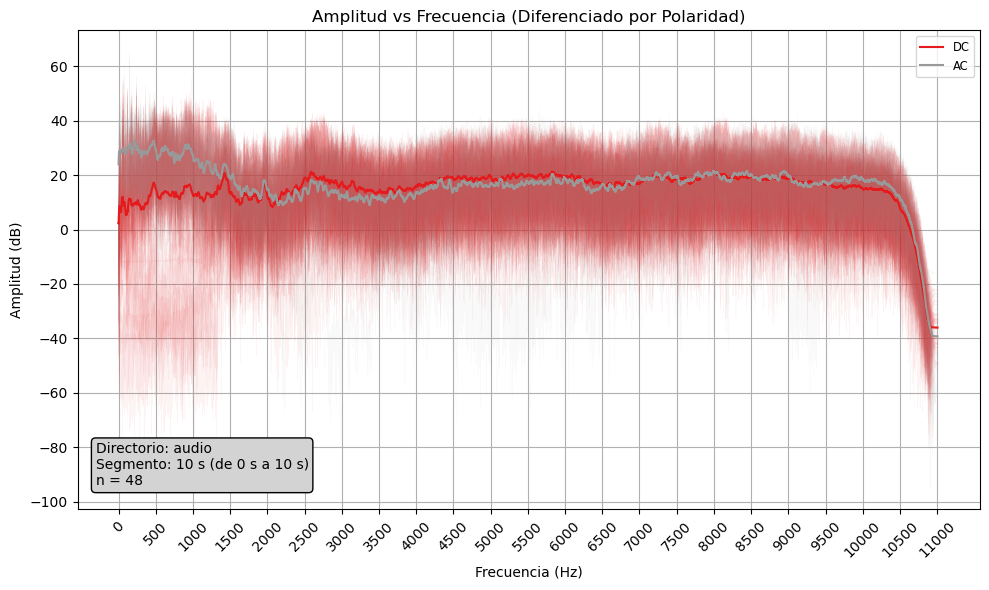

Audios ausentes: 2
Archivo no encontrado: 240826-130833_Audio.wav
Archivo no encontrado: 240826-110621_Audio.wav


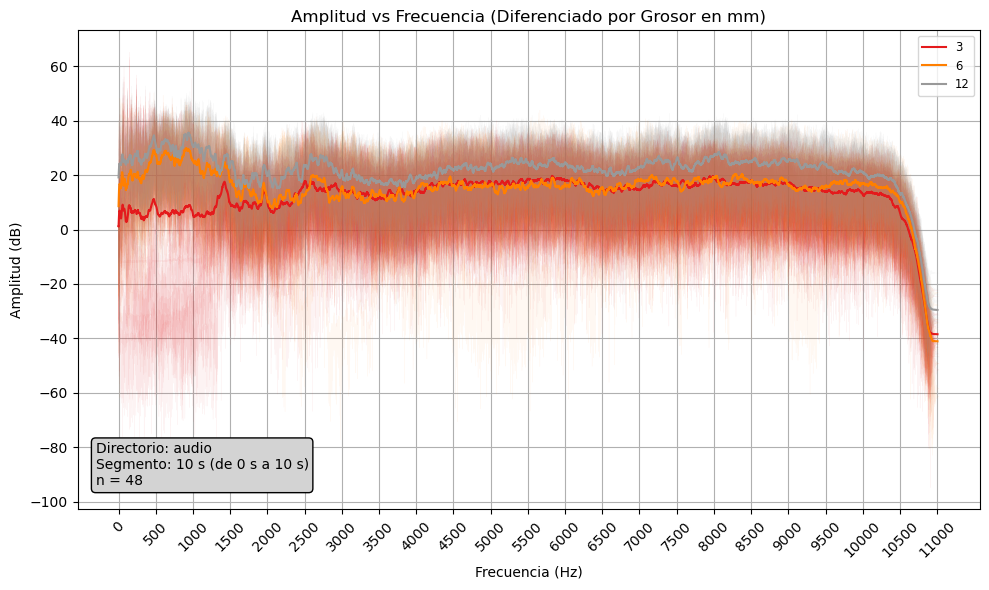

Audios ausentes: 2
Archivo no encontrado: 240826-130833_Audio.wav
Archivo no encontrado: 240826-110621_Audio.wav


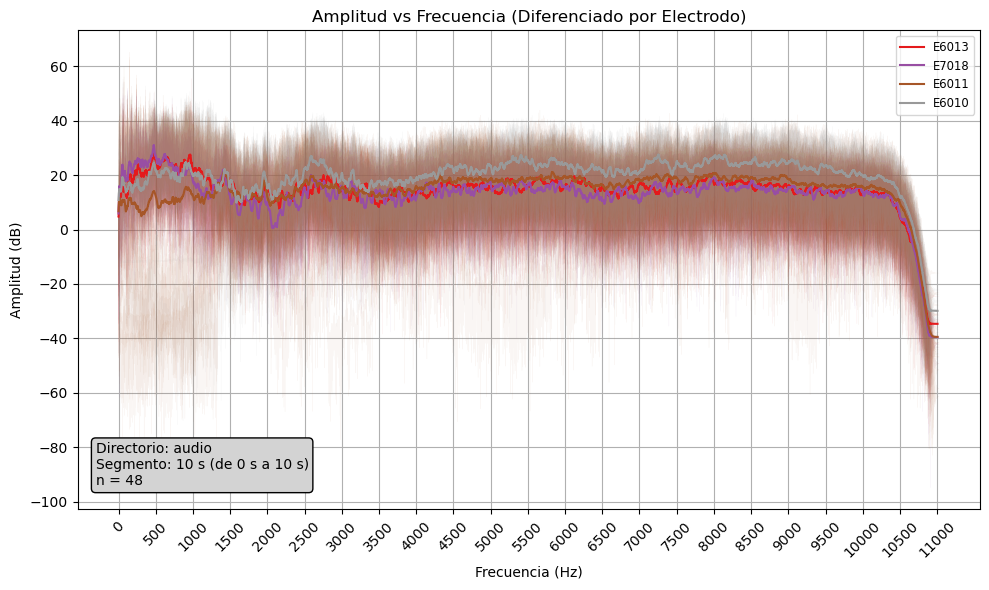

Audios ausentes: 2
Archivo no encontrado: 240826-130833_Audio.wav
Archivo no encontrado: 240826-110621_Audio.wav


In [22]:
audio_dir_1 = "audio/spleeter" 

total_plotted_audios = plot_by_category(
    data,
    "polaridad",
    "Amplitud vs Frecuencia (Diferenciado por Polaridad)",
    n,
    audio_dir_1,
)
plot_by_category(
    data,
    "grosor",
    "Amplitud vs Frecuencia (Diferenciado por Grosor en mm)",
    n,
    audio_dir_1,
)
plot_by_category(
    data,
    "electrodo",
    "Amplitud vs Frecuencia (Diferenciado por Electrodo)",
    n,
    audio_dir_1,
)
